In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass

In [5]:
altfile='{base}'
# signal = ObjIter([])
signal = ObjIter([ Tree(f, altfile=altfile, report=False) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, altfile=altfile, report=False) for f in tqdm(module.extended_signal_list) ])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

bkg = ObjIter([])
# bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile=altfile), Tree(module.Run2_UL18.TTJets, altfile=altfile)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List, altfile=altfile) ])

100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


In [6]:
analysis.register_modules()

In [7]:
import utils.analysisUtils as analysis

In [8]:
run = analysis.reconstruct_resonances()

In [9]:
from argparse import ArgumentParser

parser = ArgumentParser()
parser = run._add_parser(parser)
args, _ = parser.parse_known_args('--outfile test.root --reco-algo ranker --model-path feynnet_bkg_33sig'.split())

In [10]:
run = run.__class__(
    signal=signal,
    bkg=bkg,
    data=data,                                                                                                                                                                                         
    # use_signal=np.arange(21)[::5].tolist(),
    **vars(args)
)

In [11]:
run.run(['reconstruct_quadh'])

0:00:00 [running] reconstruct_quadh


100%|██████████| 3/3 [00:11<00:00,  3.95s/it]


0:00:12 [skipping] build_bdt_features
0:00:12 [skipping] write_trees
0:00:12 [finished]


In [12]:
signal = run.signal

In [ ]:
stu

In [9]:
run.run(['train_ar_bdt'])

0:00:00 [running] reweight_bkg
0:00:00 [error] list index out of range

0:00:00 [running] jet_kin_cuts
0:01:13 [skipping] plot_cutflow
0:01:13 [skipping] plot_ranker
0:01:13 [skipping] plot_t8btag_signal
0:01:13 [skipping] plot_eightb_signal
0:01:13 [skipping] plot_fully_reconstrcuted_id
0:01:13 [skipping] plot_global_jet_kin
0:01:13 [skipping] plot_assigned_jet_kin
0:01:13 [skipping] plot_assigned_higgs_kin
0:01:13 [skipping] plot_assigned_y_kin
0:01:13 [skipping] plot_x_kin
0:01:13 [skipping] plot_res_m
0:01:13 [running] build_higgs_rm
Calculating 4D Higgs mass peak with ASSIGNED higgs
[125 125 125 125]
0:01:34 [skipping] plot_assigned_higgs_m
0:01:34 [skipping] plot_y_higgs_m
0:01:34 [skipping] plot_abcd_variables
0:01:34 [running] build_abcd
0:01:36 [skipping] plot_abcd_composition
0:01:36 [skipping] plot_abcd_regions
0:01:36 [skipping] plot_vr_datamc
0:01:36 [skipping] train_vr1_bdt
0:01:36 [skipping] train_vr2_bdt
0:01:36 [running] train_ar_bdt
Training AR BDT
... fetching featur

In [98]:
run.plot_fully_reconstrcuted_id(run.signal)

100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


In [127]:
reco_eff = run.signal.apply(lambda t : np.mean( t.reco_id[t.nfound_select==8]==0 )).npy

(<Figure size 800x640 with 2 Axes>, <AxesSubplot:xlabel='MX', ylabel='MY'>)

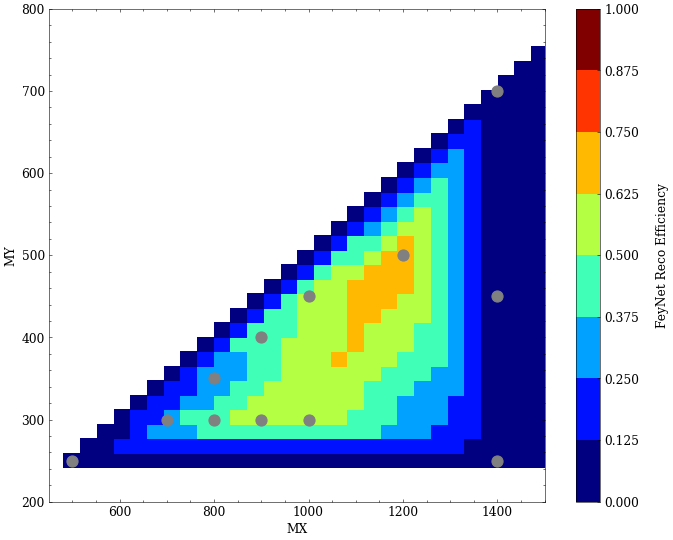

In [131]:
fig, axs = study.get_figax(size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel = 'FeyNet Reco Efficiency', 
    # xlim=(450,4050), ylim=(200,2050),
    xlim = (450,1500), ylim=(200,800),
    # logy=True, logx=True, 
)

# zlim=(0,1)
# zlim=np.logspace(-5,0,7)
zlim=np.linspace(0,1,9)
graph2d_array(mx_list, my_list, reco_eff, figax=(fig, axs), interp=True, colorbar=True, g_cmap='jet', zlim=zlim, **kwargs)
graph_array(mx_list, my_list, figax=(fig, axs), g_color='grey', g_ls='none', g_markersize=10, **kwargs)


In [10]:
run.signal.cutflow[0][0].histo

array([3.00894490e+09, 8.17638912e+08, 8.16969152e+08, 8.01848256e+08,
       7.85416640e+08, 4.65980864e+08, 4.65980864e+08, 3.79006016e+08,
       3.59061376e+08, 3.20216448e+08])

In [95]:
bkg_weights = run.bkg_model.apply(run.ar_bdt.reweight_tree).cat
bkg_X_m = run.bkg_model.X_m.cat
bkg_Y1_m = run.bkg_model.Y1_m.cat
bkg_H1Y1_m = run.bkg_model.H1Y1_m.cat
bkg_mask = run.bkg_model.apply(run.ar_bdt.b).cat

bkg_weights = bkg_weights[bkg_mask]
bkg_X_m = bkg_X_m[bkg_mask]
bkg_Y1_m = bkg_Y1_m[bkg_mask]
bkg_H1Y1_m = bkg_H1Y1_m[bkg_mask]

21it [00:02, 10.22it/s]


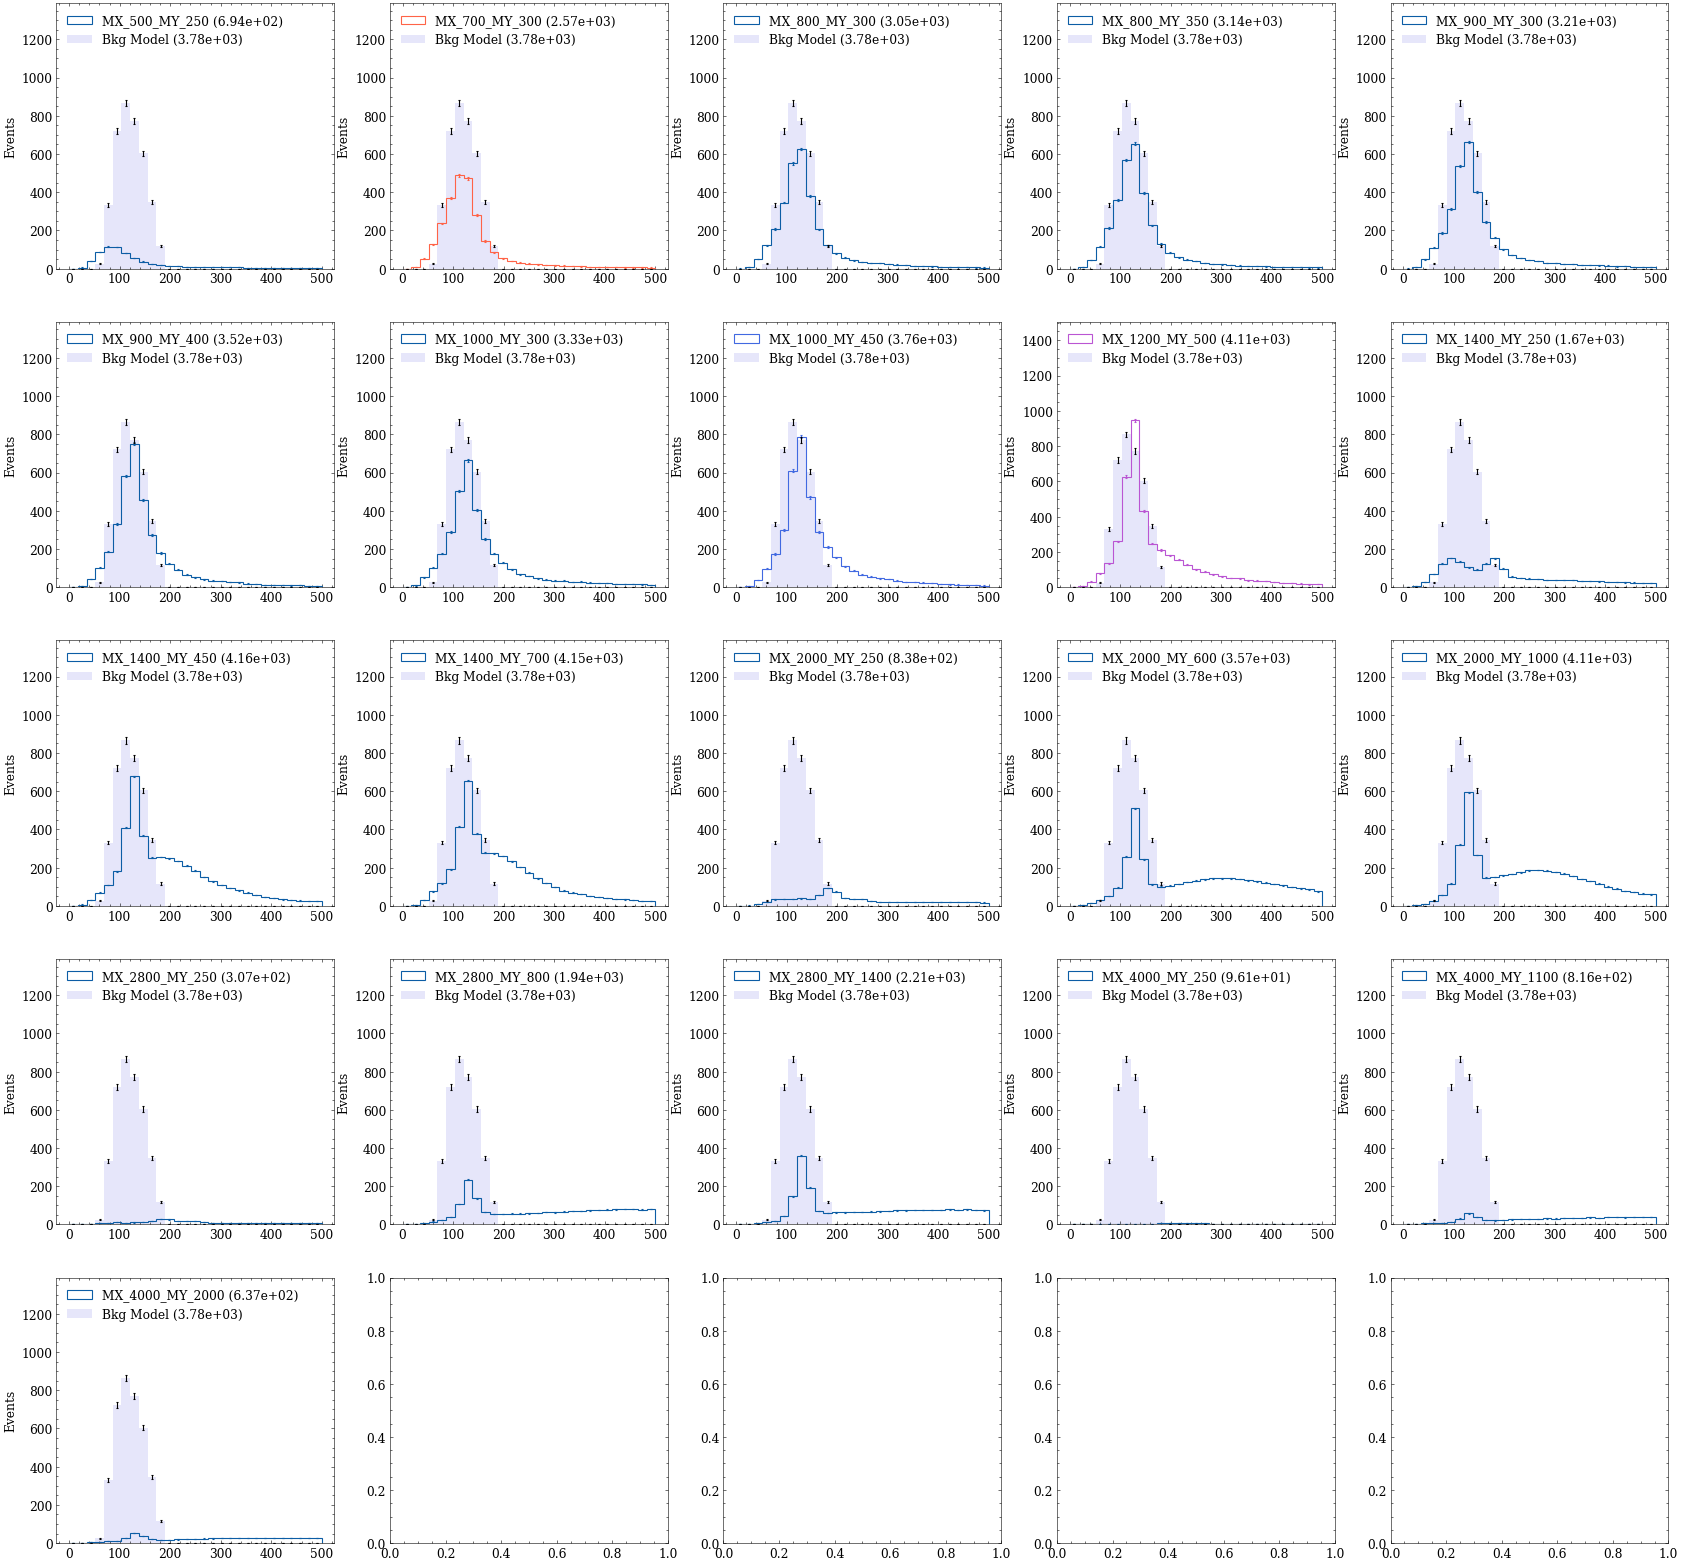

In [96]:
fig, axs = study.get_figax(nvar=25)

h_bkg = Histo.from_array(bkg_H1Y1_m, bins=(0,500,30), weights=bkg_weights, color='lavender', label='Bkg Model')
lumi, tag = lumiMap[2018]

for i, sig in tqdm(enumerate(run.signal)):
    sig_H1Y1_m = sig.H1Y1_m
    sig_weights = sig.scale
    sig_mask = run.ar_bdt.a(sig)

    h_sig = Histo.from_array(sig_H1Y1_m, bins=(0,500,30), weights=lumi*sig_weights, color=sig.color, histtype='step', label=sig.sample)
    plot_histos([h_sig, h_bkg], legend=True, figax=(fig, axs.flat[i]))

21it [00:24,  1.18s/it]


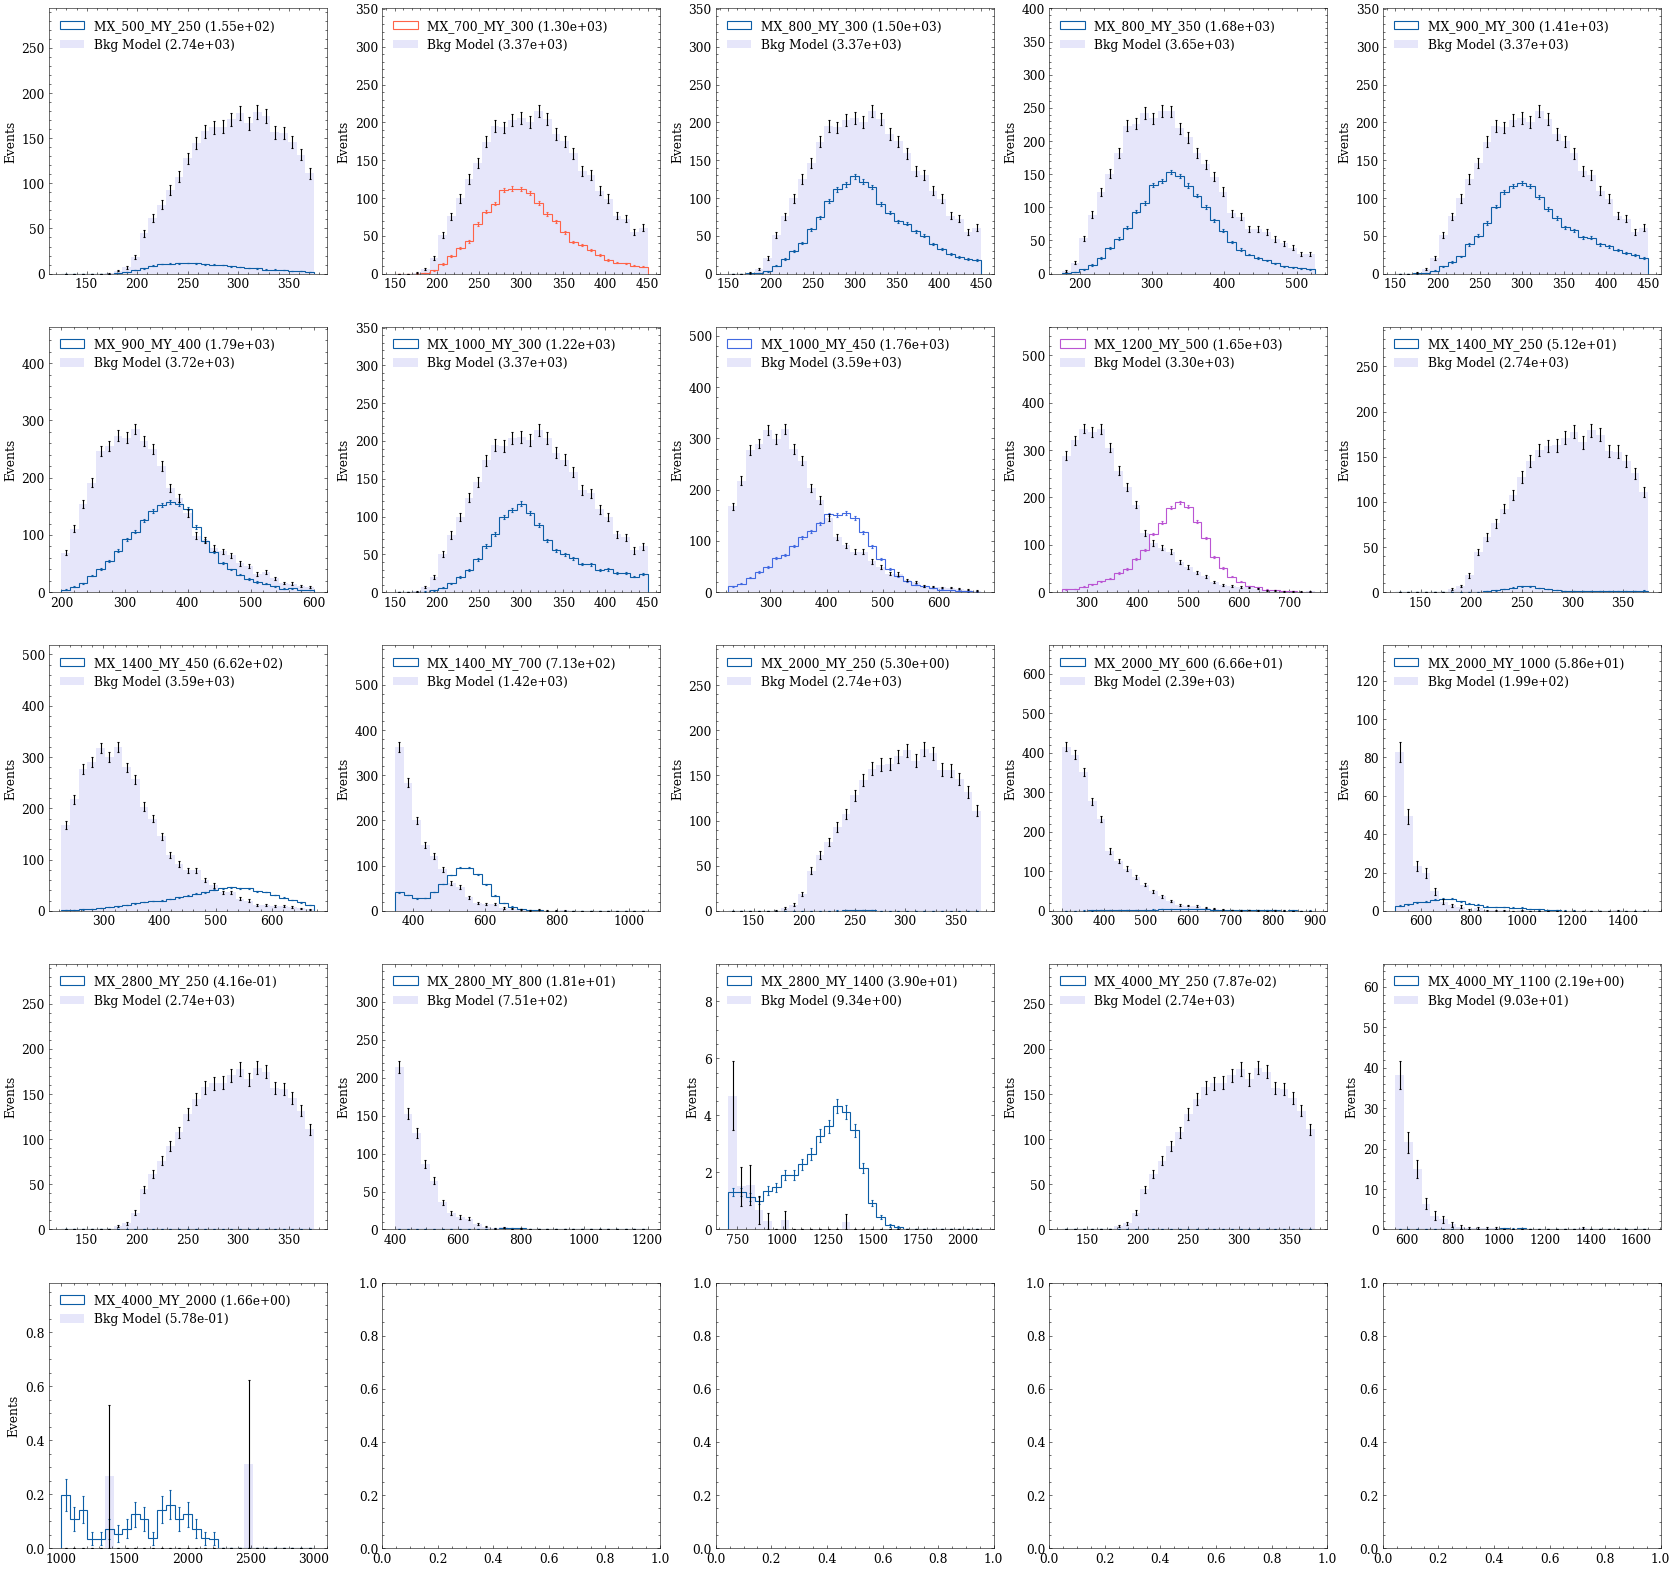

In [124]:
fig, axs = study.get_figax(nvar=25)

lumi, tag = lumiMap[2018]

for i, sig in tqdm(enumerate(run.signal)):
    mx, my = sig.sample.split('_')[1::2]
    my = int(my)

    bins = ( my*(1-0.5),my*(1+0.5),30 )

    h_bkg = Histo.from_array(bkg_Y1_m, bins=bins, weights=bkg_weights, color='lavender', label='Bkg Model')

    sig_mask = run.ar_bdt.a(sig)
    sig_Y1_m = sig.Y1_m[sig_mask]
    sig_weights = sig.scale[sig_mask]

    h_sig = Histo.from_array(sig_Y1_m, bins=bins, weights=lumi*sig_weights, color=sig.color, histtype='step', label=sig.sample)
    plot_histos([h_sig, h_bkg], legend=True, figax=(fig, axs.flat[i]))

In [45]:
def calc_limits(sig, bkg_X_m=bkg_X_m, bkg_weights=bkg_weights):
    mx, my = sig.sample.split('_')[1::2]
    mx, my = int(mx), int(my)

    sig_mask = run.ar_bdt.a(sig)
    sig_X_m = sig.X_m[sig_mask]
    sig_weights = sig.scale[sig_mask]


    mx_lo, mx_hi = max( 0, mx * (1 - 0.5) ), mx * (1 + 0.5) 

    lumi, tag = lumiMap[2018]

    h_sig = Histo.from_array(sig_X_m, bins=(mx_lo, mx_hi, 30), weights=lumi*sig_weights, color=sig.color, histtype='step', label=sig.sample)
    h_bkg = Histo.from_array(bkg_X_m, bins=(mx_lo, mx_hi, 30), weights=bkg_weights, color='lavender', label='Bkg Model')

    model = Model(h_sig, h_bkg=h_bkg)
    model.upperlimit()
    model.mx = mx
    model.my = my 
    return model


In [46]:
sig_models = run.signal.apply(calc_limits, report=True)

100%|██████████| 21/21 [01:58<00:00,  5.64s/it]


In [47]:
exp_limits = sig_models.h_sig.stats.exp_limits.apply(lambda lim : lim[2]).npy
mx_list = sig_models.mx.npy
my_list = sig_models.my.npy

21it [00:01, 11.34it/s]


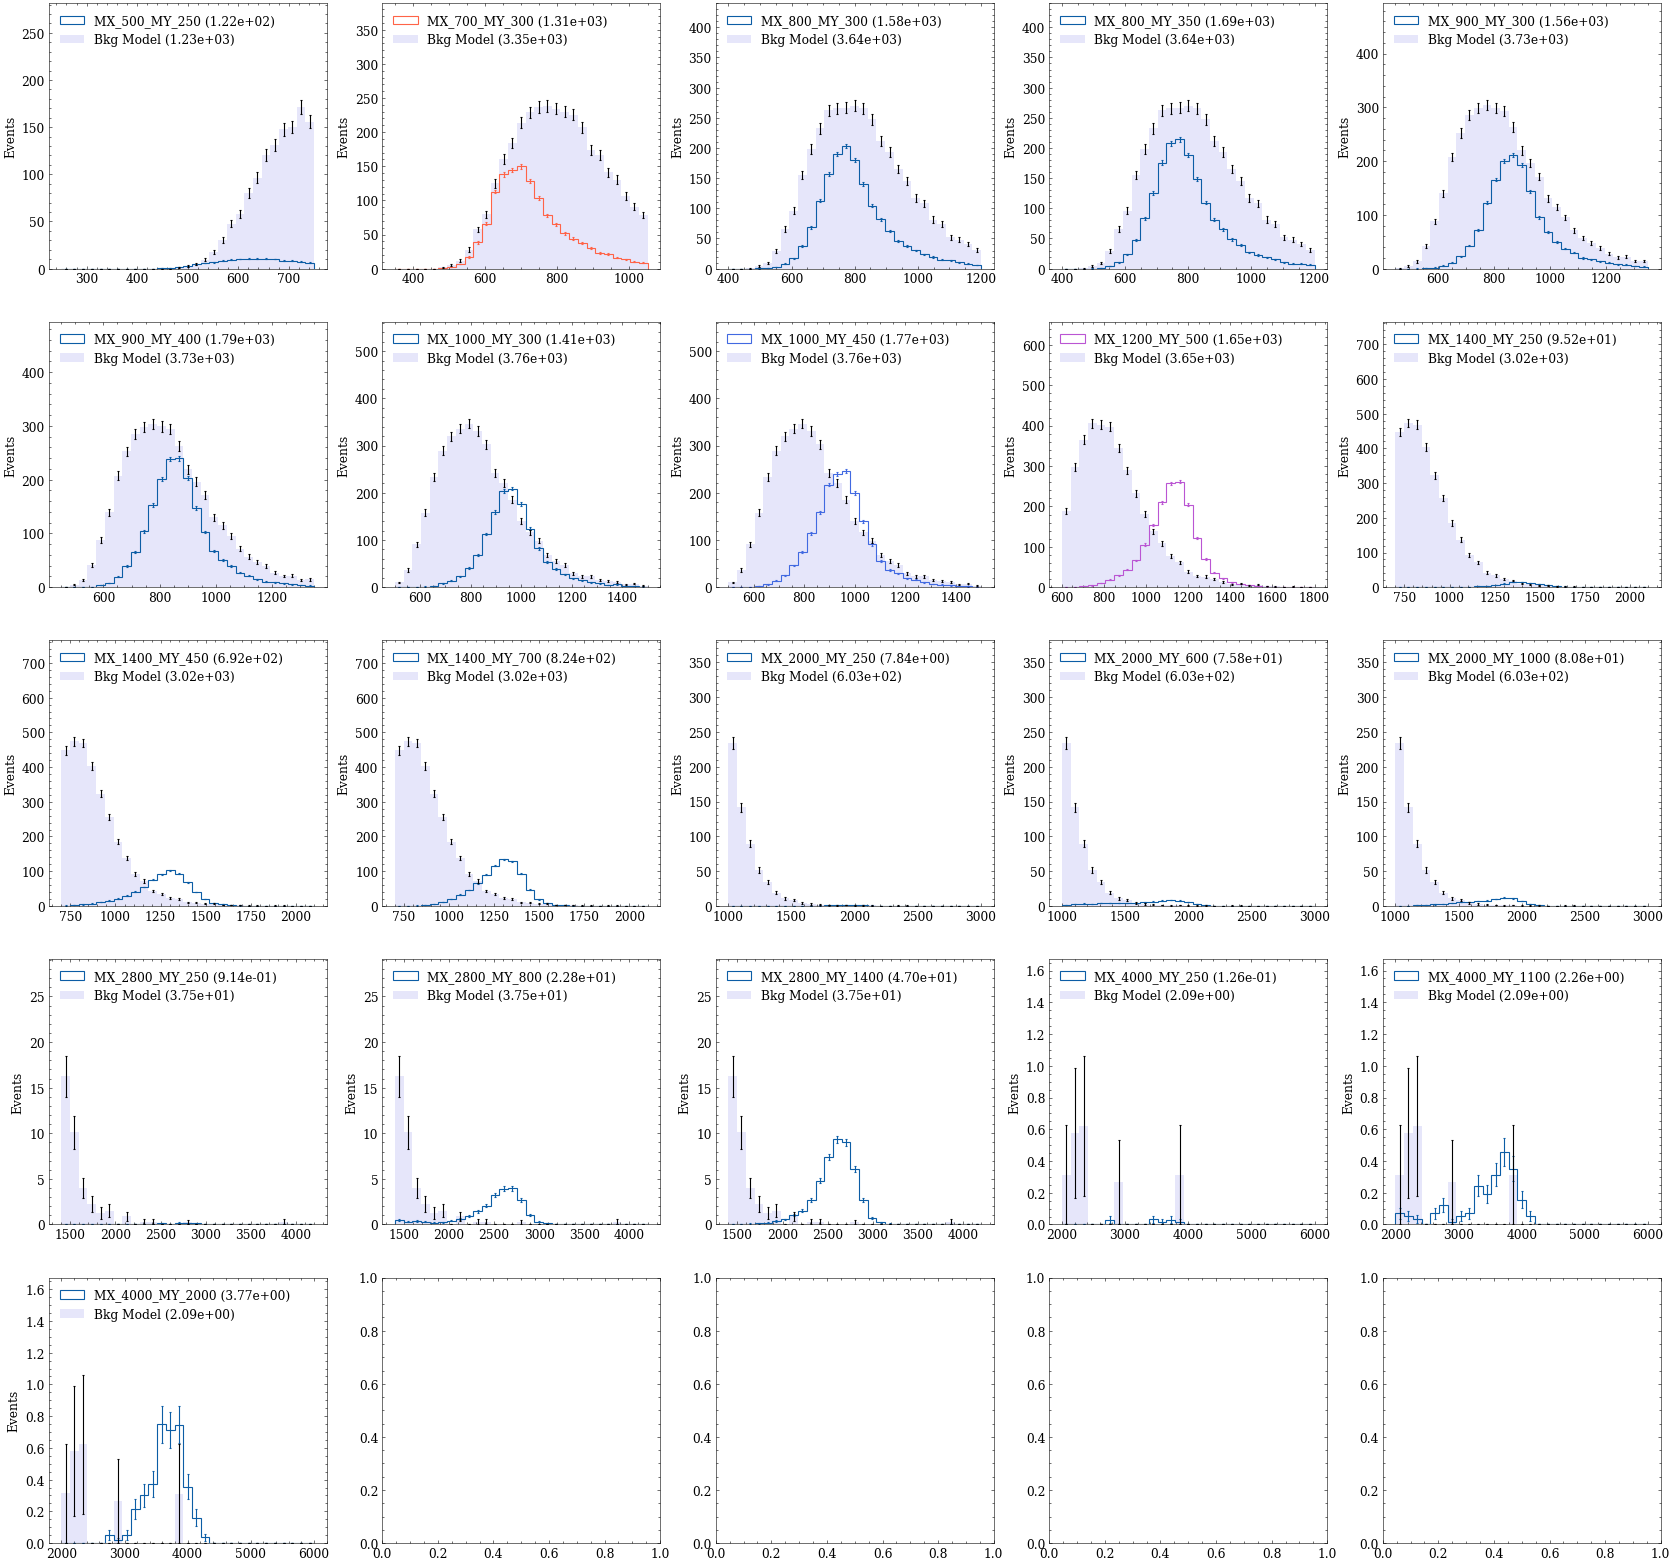

In [48]:
fig, axs = study.get_figax(nvar=25)

for i, model in tqdm(enumerate(sig_models)):
    plot_histos([model.h_sig,model.h_bkg], figax=(fig, axs.flat[i]), legend=True,)

In [91]:
np.logspace(-2,1,7)

array([ 0.01      ,  0.03162278,  0.1       ,  0.31622777,  1.        ,
        3.16227766, 10.        ])

(<Figure size 800x640 with 2 Axes>, <AxesSubplot:xlabel='MX', ylabel='MY'>)

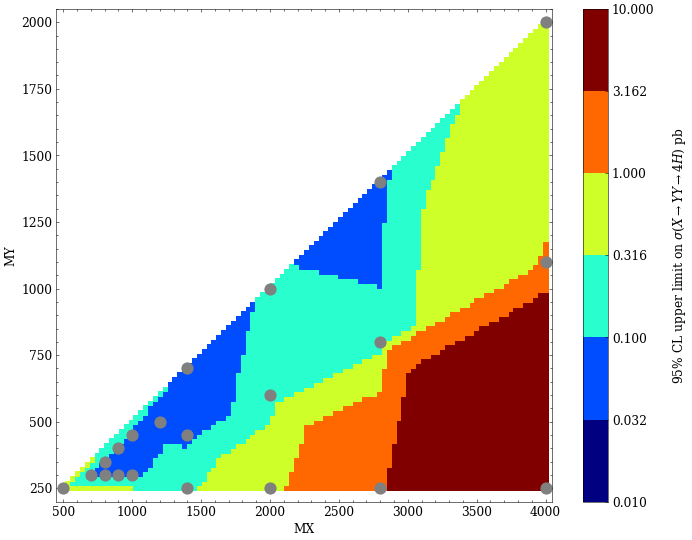

In [92]:
fig, axs = study.get_figax(size=(10,8))

kwargs = dict(
    xlabel='MX',
    ylabel='MY',
    zlabel = '95% CL upper limit on $\sigma(X\\rightarrow YY\\rightarrow 4H)$ pb', 
    xlim=(450,4050), ylim=(200,2050),
    # xlim = (600,1300), ylim=(250,550)
    # logy=True, logx=True, 
)

# zlim=(0,1)
zlim=np.logspace(-2,1,7)
# zlim=(0,0.333,0.667,1.0)
graph2d_array(mx_list, my_list, exp_limits, figax=(fig, axs), interp=dict(kind='linear'), colorbar=True, g_cmap='jet', zlim=zlim, **kwargs)
graph_array(mx_list, my_list, figax=(fig, axs), g_color='grey', g_ls='none', g_markersize=10, **kwargs)
